In [1]:
%reset -f 
# This command resets the kernel.

In [2]:
import illustris_python as il
import numpy
import random as rand
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import axes3d  
import math
import os

In [4]:
basePath = '/Users/david/Downloads' # Loads the data for a certain simulation run, in this case TNG100-3-Dark.
snapNum = 99 # Defines the snapshot number that is used when reading in the data.

In [45]:
dm = il.snapshot.loadSubset(basePath, snapNum, "DM", fields=['Velocities', 'Coordinates']) 

# Loads in the data for the specified criteria. In this case it is loading in the dark matter velocity 
# data from snapshot 99 of the TNG100-3-Dark run. 

# The data is organized into 3 columns, with the first, second, and third columns being 
# for the x, y, and z data resepctively. 


dm

{'count': 94196375,
 'Velocities': array([[ -88.18688  , -266.75388  ,  -16.47824  ],
        [ -25.844416 , -221.59425  , -156.80574  ],
        [  36.122326 , -320.14853  ,  -12.0878935],
        ...,
        [ 102.97468  ,  147.75105  , -179.23094  ],
        [ 277.45642  ,    1.5484225,  117.53938  ],
        [ 181.98972  ,   16.617556 ,  -11.09932  ]], dtype=float32),
 'Coordinates': array([[  843.99922154, 26357.79010622, 18309.58209558],
        [  848.18025182, 26356.28690729, 18309.85631705],
        [  844.35707205, 26353.84816751, 18313.78500562],
        ...,
        [60493.77570956, 49004.46033618, 56941.49036124],
        [65913.59362304, 61563.99882039, 46947.4596657 ],
        [64115.0072588 , 61436.66139752,   163.32408868]])}

In [27]:
sub_data = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloCM', 'SubhaloVel', 'SubhaloMass'])

# Loads in center of mass position ('SubhaloCM'), velocity ('SubhaloVel'), and mass ('SubhaloMass') data
# of all the subhalos from the Group Catalog for the specified basePath and snapNum.

# This relates to 'fof_halo' in that for 'sub_data', the first 24681 rows of either the CM, velocity, 
# or mass data is the data for all the subhalos that belong to the first halo. The next 19381 rows are
# data for all the subhalos belonging to the second halo, and so on.



In [28]:
sub_veldisp = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloVelDisp'])

# Loads in velocity dispersion data of all the subhalos from the Group Catalog for the 
# specified basePath and snapNum.

# This gives you the 1-dimensional velocity dispersion for each subhalo. 


In [29]:
sub_single = il.groupcat.loadSingle(basePath, snapNum, subhaloID=1)

# Loads in subhalo data for all the fields of a single subhalo.

# The 'loadSingle' function does not load particle level data. For example, the 'SubhaloMass' field 
# of 'sub_single' gives you one value which is the mass of the entire subhalo, not the 
# masses of each particle in that subhalo. Similarly, 'SubhaloVel' gives you the x, y, and z 
# velocity for the subhalo itself, not for the subhalos' particles. 

# To change which subhalo the data is for, change the number assigned to 'subhaloID'. 


In [14]:
fof_halo = il.groupcat.loadHalos(basePath, snapNum, fields=['GroupFirstSub'])

# Loads in the TNG100-3-Dark halo data for the 'GroupFirstSub' field.

# The 'GroupFirstSub' field gives the starting index of each halo, and thus tells how many subhalos are in each halo. 

# For example, the first three items in 'fof_halo' are 0, 24681, and 44062. This means that for the first halo 
# it has starting index 0 and has 24681 - 0 = 24681 subhalos in it. For the second halo, index 24681, it has 
# 44062 - 24681 = 19381 subhalos in it, and so on.  

fof_halo

array([     0,    626,   1051, ..., 116017, 116018, 116019], dtype=int32)

In [17]:
#Finding indices for second and third halo
fof_halo[1:3]

array([ 626, 1051], dtype=int32)

In [18]:
1051-626   #This tells how many subhalos are in the second halo. There are 425 subhalos in the second halo. 

425

In [21]:
fof_halo[4:6] #Finding indices for fifth and sixth subhalo 

array([1823, 2137], dtype=int32)

In [22]:
2137-1823     #This tells how many subhalos are in the second halo. There are 314 subhalos in the second halo. 

314

In [23]:
fof_halo[9:11] #Finding indices for tenth and eleventh subhalos 

array([3194, 3365], dtype=int32)

In [24]:
3365-3194     #This tells how many subhalos are in the second halo. There are 171 subhalos in the second halo. 

171

In [25]:
# Trying to recreate the above code in Python, we set these two variables equal to 1:
vel_to_phys = 1
H_of_a = 1 


dm_part_mass = (1.7 * 10**37)
# To get this value, we take the mass of each particle in units of (mass of sun)/h, 
# which is 0.000599968882709879, and converted it to kg. Using h as 0.7, the calculation is as follows:

# (0.000599968882709879 * (10**10) * (2 * 10**30)) / .7 = 1.7141968077425118e+37,
# which can then be rounded to (1.7 * 10**37).

dm_part_mass

1.6999999999999998e+37

In [30]:
# If doing calculations to test the following algorithm, here is a copy of 'snap_sub' and 'sub_single' 
# for convenience (change the 'xx' to change which subhalo the data is for):

xx = 100
snap_sub = il.snapshot.loadSubhalo(basePath, snapNum, xx, 'dm', fields=['Velocities'])
sub_single = il.groupcat.loadSingle(basePath, snapNum, subhaloID=xx)


In [31]:
# A recreated Python algorithm of the code Dylan Nelson sent us that 
# finds the velocity dispersion for a specified subhalo.  

disp = 0
mass = 0

for i in range(len(snap_sub)):
    # This next If Statement is a progress bar of sorts which tells you how far along in the 
    # For Loop you are. This is useful for when the For Loop takes a while.  
    # The '0.1' means it updates you every 10%. Changing that number to, say, 0.05, will update you every 5%. 
    if (i%(int(len(range(len(snap_sub)))*0.1)) == 0):
        print(f"{round(i/(len(snap_sub))*100)} % completed")
    for j in range(3): # This has j loop over 1, 2, then 3, making it loop over the x, y, then z data, respectively. 
        dx = 1
        dv = vel_to_phys * (snap_sub[i,j] - sub_single['SubhaloVel'][j])
        dv += H_of_a * dx # Multiplying 'H_of_a' by 'dx' and summing.

        disp += dm_part_mass * dv * dv # Multiplying the mass of each particle by dv^2 and summing.

mass = dm_part_mass * len(snap_sub) # Multiplying the mass of each particle by the number 
# of particles to get the total mass of the subhalo. 

veldisp = math.sqrt(disp / (3 * mass)) # Calculating the 1-dimensional velocity dispersion. 

print(f'For subhalo {xx}, the velocity disperion is: ', veldisp)

0 % completed
10 % completed
19 % completed
29 % completed
39 % completed
48 % completed
58 % completed
68 % completed
77 % completed
87 % completed
97 % completed
For subhalo 100, the velocity disperion is:  41.05719136528504


In [33]:
# Velocity data for every 5th subhalo within the first halo:
x_vel_1 = sub_data['SubhaloVel'][0:24681:5,0] # x velocity data.
y_vel_1 = sub_data['SubhaloVel'][0:24681:5,1] # y velocity data.
z_vel_1 = sub_data['SubhaloVel'][0:24681:5,2] # z velocity data.

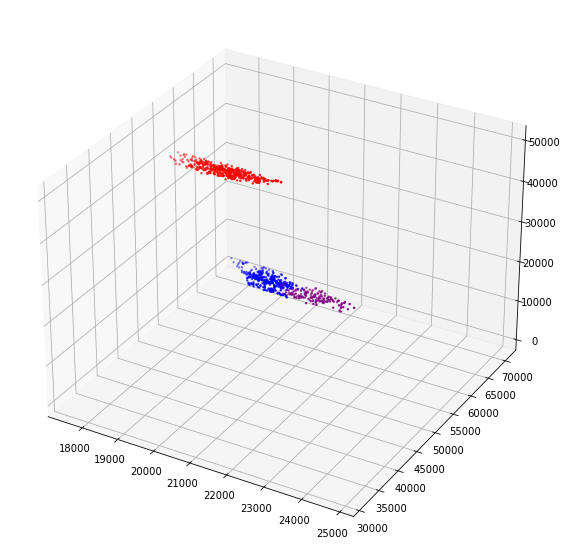

In [46]:
# Gathering velocity info for all subhalos in halo 2

x_vel_2 = sub_data['SubhaloCM'][626:1051,0]
y_vel_2 = sub_data['SubhaloCM'][626:1051,1]
z_vel_2 = sub_data['SubhaloCM'][626:1051,2]




x_vel_5 = sub_data['SubhaloCM'][1823:2137,0]
y_vel_5 = sub_data['SubhaloCM'][1823:2137,1]
z_vel_5 = sub_data['SubhaloCM'][1823:2137,2]



x_vel_10 = sub_data['SubhaloCM'][3194:3365,0]
y_vel_10 = sub_data['SubhaloCM'][3194:3365,1]
z_vel_10 = sub_data['SubhaloCM'][3194:3365,2]
fig = plot.figure(figsize=(10,10)) # Creates the figure.
ax = fig.gca(projection='3d') # Creates the 3D figure.

ax.scatter(x_vel_2, y_vel_2, z_vel_2, c='red', label='zs=0, zdir=x', s=2) # Plots the velocity data for the second halo.
ax.scatter(x_vel_5,y_vel_5,z_vel_5,c='blue', label='zs=0, zdir=x', s=2)
ax.scatter(x_vel_10,y_vel_10,z_vel_10,c='purple', label='zs=0, zdir=x', s=2)

In [39]:
# Trying to recreate the above code in Python, we set these two variables equal to 1:
vel_to_phys = 1
H_of_a = 1 


dm_part_mass = (1.7 * 10**37)
# To get this value, we take the mass of each particle in units of (mass of sun)/h, 
# which is 0.000599968882709879, and converted it to kg. Using h as 0.7, the calculation is as follows:

# (0.000599968882709879 * (10**10) * (2 * 10**30)) / .7 = 1.7141968077425118e+37,
# which can then be rounded to (1.7 * 10**37).

dm_part_mass

1.6999999999999998e+37

In [40]:
# If doing calculations to test the following algorithm, here is a copy of 'snap_sub' and 'sub_single' 
# for convenience (change the 'xx' to change which subhalo the data is for):

xx = 100
snap_sub = il.snapshot.loadSubhalo(basePath, snapNum, xx, 'dm', fields=['Velocities'])
sub_single = il.groupcat.loadSingle(basePath, snapNum, subhaloID=xx)


In [41]:
# A recreated Python algorithm of the code Dylan Nelson sent us that 
# finds the velocity dispersion for a specified subhalo.  

disp = 0
mass = 0

for i in range(len(snap_sub)):
    # This next If Statement is a progress bar of sorts which tells you how far along in the 
    # For Loop you are. This is useful for when the For Loop takes a while.  
    # The '0.1' means it updates you every 10%. Changing that number to, say, 0.05, will update you every 5%. 
    if (i%(int(len(range(len(snap_sub)))*0.1)) == 0):
        print(f"{round(i/(len(snap_sub))*100)} % completed")
    for j in range(3): # This has j loop over 1, 2, then 3, making it loop over the x, y, then z data, respectively. 
        dx = 1
        dv = vel_to_phys * (snap_sub[i,j] - sub_single['SubhaloVel'][j])
        dv += H_of_a * dx # Multiplying 'H_of_a' by 'dx' and summing.

        disp += dm_part_mass * dv * dv # Multiplying the mass of each particle by dv^2 and summing.

mass = dm_part_mass * len(snap_sub) # Multiplying the mass of each particle by the number 
# of particles to get the total mass of the subhalo. 

veldisp = math.sqrt(disp / (3 * mass)) # Calculating the 1-dimensional velocity dispersion. 

print(f'For subhalo {xx}, the velocity disperion is: ', veldisp)

0 % completed
10 % completed
19 % completed
29 % completed
39 % completed
48 % completed
58 % completed
68 % completed
77 % completed
87 % completed
97 % completed
For subhalo 100, the velocity disperion is:  41.05719136528504


In [44]:
snap_sub = il.snapshot.loadSubhalo(basePath, snapNum, xx, 'dm', fields=['Velocities'])

snap_sub

array([[ 209.85875 ,  206.51155 ,  919.8539  ],
       [ 219.5629  ,  223.17781 ,  956.9693  ],
       [ 225.88773 ,  227.81836 ,  922.01    ],
       [ 260.60797 ,  191.08937 ,  975.1756  ],
       [ 232.13329 ,  199.6045  ,  916.96185 ],
       [ 249.27504 ,  226.7787  ,  948.3234  ],
       [ 221.35988 ,  214.05843 ,  961.6074  ],
       [ 198.70192 ,  269.77844 ,  936.6406  ],
       [ 243.99223 ,  254.03543 ,  920.205   ],
       [ 214.84799 ,  168.56497 ,  911.65894 ],
       [ 219.80869 ,  251.17686 ,  926.88806 ],
       [ 233.03036 ,  184.78549 ,  935.35205 ],
       [ 203.8047  ,  221.73036 ,  987.941   ],
       [ 251.99165 ,  145.69746 ,  899.2748  ],
       [ 200.0608  ,  258.0272  ,  966.73804 ],
       [ 205.49855 ,  238.94766 ,  989.2352  ],
       [ 265.28488 ,  203.22437 ,  900.93616 ],
       [ 210.63339 ,  182.95216 ,  977.7329  ],
       [ 223.54109 ,  287.62936 ,  989.798   ],
       [ 243.80635 ,  193.47313 ,  969.00146 ],
       [ 291.93683 ,  199.20581 ,  958.6